<a href="https://colab.research.google.com/github/danielruskin/inst808_fall_2025_final_project/blob/main/inst_808_final_project_main_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load data

In [1]:
# Optional code block for mounting your Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import necessary modules

In [2]:
import pandas as pd
import os
import re
import string
from datetime import datetime
import numpy as np
from ast import literal_eval # for reading tokens
import random

In [3]:
data_path = '/content/drive/My Drive/Courses/INST808'

# Load preprocessed nyt data
file_path_nyt = os.path.join(data_path, 'nyt_ads_modified_preprocessed.tsv')
df_nyt = pd.read_csv(file_path_nyt, sep='\t', converters={'final_tokens': literal_eval, 'spacy': literal_eval}) # make sure tokens are processed as a column of lists

# Load preprocessed facebook data
file_path_facebook = os.path.join(data_path, 'facebook_ads_modified_preprocessed.tsv')
df_facebook = pd.read_csv(file_path_facebook, sep='\t', converters={'final_tokens': literal_eval, 'spacy': literal_eval}) # make sure tokens are processed as a column of lists

Generate overall statistics about data

In [4]:
# Sort dates for nyt data, so that we can see start and end dates
df_nyt['date'].sort_values()

,date
47,1972-12-21
38,1984-08-16
27,1988-11-03
58,1989-07-06
32,1992-04-09
...,...
46,2008-06-24
5,2009-01-20
55,2009-05-22
51,2009-06-29


In [5]:
# Sort dates for facebook data, so that we can see start and end dates
df_facebook['start'].sort_values()

,start
508,2019-09-23
505,2019-11-18
507,2019-11-18
506,2019-11-20
504,2019-11-28
...,...
4,2025-08-29
3,2025-08-29
2,2025-10-07
1,2025-10-13


In [6]:
df_nyt['date'] = pd.to_datetime(df_nyt['date']) # convert dates to datetime in pandas
df_nyt['year'] = df_nyt['date'].dt.year # grab year

df_facebook['start'] = pd.to_datetime(df_facebook['start']) # convert start dates to datetime in pandas
df_facebook['year'] = df_facebook['start'].dt.year # grab year

Text(0.5, 1.0, 'Number of Mobil/ExxonMobil NYT Advertorials Over Time')

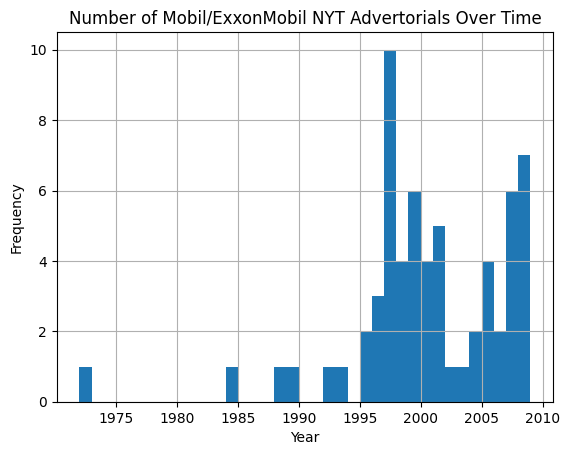

In [7]:
ax = df_nyt['year'].hist(bins=37) # do histogram showing frequency in each year
ax.set_xlabel("Year")
ax.set_ylabel("Frequency")
ax.set_title("Number of Mobil/ExxonMobil NYT Advertorials Over Time")

Text(0.5, 1.0, 'Number of ExxonMobil Facebook Ads Over Time')

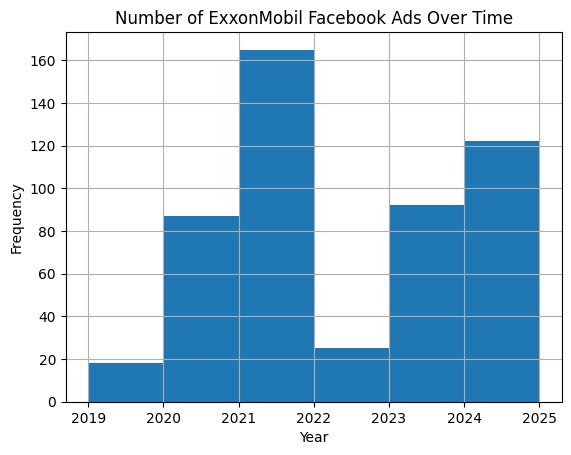

In [8]:
ax = df_facebook['year'].hist(bins=6) # do histogram showing frequency in each year
ax.set_xlabel("Year")
ax.set_ylabel("Frequency")
ax.set_title("Number of ExxonMobil Facebook Ads Over Time")

Import modules for topic modeling

In [9]:
# IMPORTANT: Must restart session after running this, due to numpy issue. Running the code should work the second time
!pip install tomotopy # For LDA topic modeling
!pip install tmplot # For LDA visualization
!pip install bertopic # For BERTopic

  Using cached tmplot-0.3.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached jedi-0.19.2-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.4 MB/s eta 0:00:00


In [10]:
import tomotopy as tp
import tmplot as tmp
from bertopic import BERTopic
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


Combine documents from Facebook such that their sizes are similar to NYT documents. I will use these revised documents for Fightin' Words and LDA

In [11]:
nyt_avg_size = np.mean([len(text) for text in df_nyt['text_modified_2']])
print(f'Average number of characters in nyt ad: {nyt_avg_size}')

Average number of characters in nyt ad: 3003.5396825396824


In [13]:
facebook_avg_size = np.mean([len(text) for text in df_facebook['ad_text_modified_2']])
print(f'Average number of characters in fb ad: {facebook_avg_size}')

Average number of characters in fb ad: 142.47347740667976


In [14]:
print(f'nyt ads are {nyt_avg_size/facebook_avg_size} as large as fb ads')

nyt ads are 21.08139519867481 as large as fb ads


In [15]:
# Combine facebook documents consecutively until their size is greater than the average nyt ad size
# Save combined text (for Fightin' Words) and combined tokens (for LDA)
revised_facebook_text = []
revised_facebook_tokens = []
temporary_text = ""
temporary_tokens = []
total_text_length = 0
for i, text in enumerate(df_facebook['ad_text_modified_2']):
  total_text_length += len(text)
  temporary_text = temporary_text + text + " "
  temporary_tokens.extend(df_facebook['final_tokens'].iloc[i])
  if total_text_length > nyt_avg_size:
    total_text_length = 0
    revised_facebook_text.append(temporary_text)
    revised_facebook_tokens.append(temporary_tokens)
    temporary_text = ""
    temporary_tokens = []

In [16]:
print(f'number of fb documents after combining for Fightin Words / LDA: {len(revised_facebook_tokens)}')

number of fb documents after combining for Fightin Words / LDA: 23


In [18]:
facebook_avg_size = np.mean([len(text) for text in revised_facebook_text])
print(f'Average number of characters in fb ad after combining documents: {facebook_avg_size}')

Average number of characters in fb ad after combining documents: 3106.304347826087


In [19]:
print(f'Average number of characters in nyt ad: {nyt_avg_size}')

Average number of characters in nyt ad: 3003.5396825396824


#Fightin' Words

In [20]:
# Use pre-existing function for fightin' words from https://github.com/jmhessel/FightingWords/blob/master/fighting_words_py3.py

# Implementation for log-odds ratios. Run but do not modify this cell!

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer as CV
import string
exclude = set(string.punctuation)

def basic_sanitize(in_string):
    '''Returns a very roughly sanitized version of the input string.'''
    in_string = ''.join([ch for ch in in_string if ch not in exclude])
    in_string = in_string.lower()
    in_string = ' '.join(in_string.split())
    return in_string

def bayes_compare_language(l1, l2, ngram = 1, prior=.01, cv = None):
    '''
    Arguments:
    - l1, l2; a list of strings from each language sample
    - ngram; an int describing up to what n gram you want to consider (1 is unigrams,
    2 is bigrams + unigrams, etc). Ignored if a custom CountVectorizer is passed.
    - prior; either a float describing a uniform prior, or a vector describing a prior
    over vocabulary items. If you're using a predefined vocabulary, make sure to specify that
    when you make your CountVectorizer object.
    - cv; a sklearn.feature_extraction.text.CountVectorizer object, if desired.

    Returns:
    - A list of length |Vocab| where each entry is a (n-gram, zscore) tuple.'''
    if cv is None and type(prior) is not float:
        print("If using a non-uniform prior:")
        print("Please also pass a count vectorizer with the vocabulary parameter set.")
        quit()
    l1 = [basic_sanitize(l) for l in l1]
    l2 = [basic_sanitize(l) for l in l2]
    if cv is None:
        # DANIEL EDITED MIN_DF TO 1, SINCE WE ARE DEALING WITH FEWER DOCUMENTS
        cv = CV(decode_error = 'ignore', min_df = 1, max_df = 0.5, ngram_range=(1,ngram),
                binary = False,
                max_features = 15000)
    counts_mat = cv.fit_transform(l1+l2).toarray()
    # Now sum over languages...
    vocab_size = len(cv.vocabulary_)
    print("Vocab size is {}".format(vocab_size))
    if type(prior) is float:
        priors = np.array([prior for i in range(vocab_size)])
    else:
        priors = prior
    z_scores = np.empty(priors.shape[0])
    count_matrix = np.empty([2, vocab_size], dtype=np.float32)
    count_matrix[0, :] = np.sum(counts_mat[:len(l1), :], axis = 0)
    count_matrix[1, :] = np.sum(counts_mat[len(l1):, :], axis = 0)
    a0 = np.sum(priors)
    n1 = 1.*np.sum(count_matrix[0,:])
    n2 = 1.*np.sum(count_matrix[1,:])
    print("Comparing language...")
    for i in range(vocab_size):
        #compute delta
        term1 = np.log((count_matrix[0,i] + priors[i])/(n1 + a0 - count_matrix[0,i] - priors[i]))
        term2 = np.log((count_matrix[1,i] + priors[i])/(n2 + a0 - count_matrix[1,i] - priors[i]))
        delta = term1 - term2
        #compute variance on delta
        var = 1./(count_matrix[0,i] + priors[i]) + 1./(count_matrix[1,i] + priors[i])
        #store final score
        z_scores[i] = delta/np.sqrt(var)
    index_to_term = {v:k for k,v in cv.vocabulary_.items()}
    sorted_indices = np.argsort(z_scores)
    return_list = []
    for i in sorted_indices:
        return_list.append((index_to_term[i], z_scores[i]))
    return return_list

In [21]:
# Run Fightin' Words to compare nyt ads and combined fb ads. Allow for bigrams to be made, so that we can also consider 2-word phrases
log_odds_scores = bayes_compare_language(df_nyt['text_modified_2'], revised_facebook_text, ngram=2)

Vocab size is 15000
Comparing language...


In [22]:
most_nyt = log_odds_scores[-25:][::-1] # Reverse list so that most associated word is printed first
most_facebook = log_odds_scores[:25]
most_nyt_words = [pair[0] for pair in most_nyt]
most_facebook_words = [pair[0] for pair in most_facebook]
print(f'Top 25 words most associated with nyt ads: {most_nyt_words}')
print(f'Top 25 words most associated with facebook ads: {most_facebook_words}')

Top 25 words most associated with nyt ads: ['they', 'greenhouse', 'would', 'or', 'their', 'world', 'developing', 'years', 'fuel', 'and the', 'also', 'dioxide', 'carbon dioxide', 'environmental', 'countries', 'fuels', 'should', 'on the', 'some', 'over the', 'science', 'may', 'greenhouse gas', 'we are', 'even']
Top 25 words most associated with facebook ads: ['you', 'state', 'your', 'support', 'jobs', 'oil and', 'oil', 'help', 'natural gas', 'today', 'how', 'action', 'capture', 'take', 'storage', 'know', 'and gas', 'learn', 'and storage', 'natural', 'capture and', 'and natural', 'american', 'production', 'carbon capture']


#LDA

Run LDA

In [23]:
def train_lda(tokenized_docs,k=20,num_passes=500,seed=42,rm_top=50,min_df=10):
  # Create an LDAModel object with the provided arguments
  # Iterate through tokenized_docs and add them to the model
  # Train the model for num_passes passes through the corpus, and optimize the parameters every 10 iterations
  # Return the trained model
  lda_model = tp.LDAModel(k=k,seed=seed,rm_top=rm_top,min_df=min_df) # train with all applicable parameters given
  for doc in tokenized_docs: # add every doc to the model
    lda_model.add_doc(doc)
  for i in range(0, num_passes, 10): # train the model through num_passes passes thru the corpus
    lda_model.train(10) # optimize every 10 iters
  return lda_model

In [24]:
# run LDA on nyt ads. Generate 20 topics
# elimintate any vocab restrictions, since dataset is small and stopwords are already removed
lda_model_nyt = train_lda(df_nyt['final_tokens'], k=20, rm_top=0, min_df=0)
lda_model_nyt.summary()

<Basic Info>
| LDAModel (current version: 0.13.0)
| 63 docs, 15346 words
| Total Vocabs: 3440, Used Vocabs: 3440
| Entropy of words: 7.17837
| Entropy of term-weighted words: 7.17837
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 500, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -8.07452
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 42 (random seed)
| trained in version 0.13.0
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.40448958 0.2104087

In [25]:
# Run LDA on fb ads. Generate 20 topics
# elimintate any vocab restrictions, since dataset is small and stopwords are already removed
lda_model_facebook = train_lda(revised_facebook_tokens, k=20, rm_top=0, min_df=0)
lda_model_facebook.summary()

<Basic Info>
| LDAModel (current version: 0.13.0)
| 23 docs, 6066 words
| Total Vocabs: 814, Used Vocabs: 814
| Entropy of words: 5.73315
| Entropy of term-weighted words: 5.73315
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 500, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -5.89077
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 42 (random seed)
| trained in version 0.13.0
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.14597201 0.05145736 0

Visualize LDA results for NYT, then FB

In [ ]:
# NOTE: I cleared the output because it uses widgets, and github could not preview the ipynb when widgets were being used
tmp.report(lda_model_nyt, docs=df_nyt['final_tokens'].tolist())

In [ ]:
# NOTE: I cleared the output because it uses widgets, and github could not preview the ipynb when widgets were being used
tmp.report(lda_model_facebook, docs=revised_facebook_tokens)

Plot overall distribution across topics

In [28]:
overall_topic_dist = [0]*20
# sum up topic distributions for all documents
for doc in lda_model_nyt.docs:
  topic_dist = doc.get_topic_dist()
  overall_topic_dist += topic_dist
# divide by number of documents to get mean probability distribution across all documents
overall_topic_dist = overall_topic_dist/len(lda_model_nyt.docs)
print(overall_topic_dist)

[0.03804522 0.02896115 0.06534645 0.03439459 0.02081869 0.01582025
 0.08962655 0.02111215 0.04783065 0.10102174 0.07512508 0.05139757
 0.03554062 0.06500026 0.02944213 0.04689909 0.02526329 0.06608497
 0.07630224 0.06596727]


Text(0.5, 0, 'Topic (number - top phrase)')

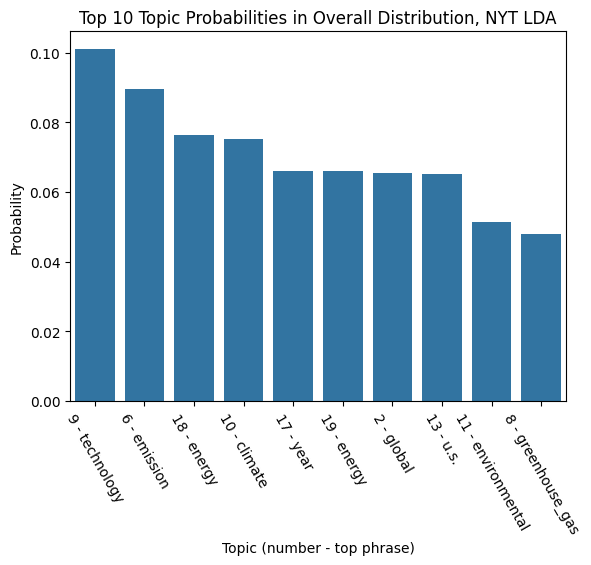

In [29]:
import seaborn as sns
topics = []
for i in range(20):
  # get topic number - word(s) combo for each topic
  topic_words = [w[0] for w in lda_model_nyt.get_topic_words(i, top_n=1)]
  topics.append(f'{i} - {', '.join(topic_words)}')

# Create barplot of probabilities vs topics
data = {'Topic': topics,
        'Probability': overall_topic_dist}
df = pd.DataFrame(data).sort_values(by='Probability',ascending=False)[:10] # get top 10 topics
g = sns.barplot(data=df, x='Topic', y='Probability')
g.tick_params(axis='x', rotation=300)
g.set_title("Top 10 Topic Probabilities in Overall Distribution, NYT LDA")
g.set_xlabel("Topic (number - top phrase)")


In [30]:
overall_topic_dist = [0]*20
# sum up topic distributions for all documents
for doc in lda_model_facebook.docs:
  topic_dist = doc.get_topic_dist()
  overall_topic_dist += topic_dist
# divide by number of documents to get mean probability distribution across all documents
overall_topic_dist = overall_topic_dist/len(lda_model_facebook.docs)
print(overall_topic_dist)

[0.052833   0.041404   0.04637653 0.08291729 0.0981807  0.05563767
 0.01667376 0.03136525 0.03499055 0.07034137 0.09628738 0.02873796
 0.04833343 0.03601213 0.03694651 0.02827269 0.06666885 0.01516025
 0.0183565  0.0945042 ]


Text(0.5, 0, 'Topic (number - top phrase)')

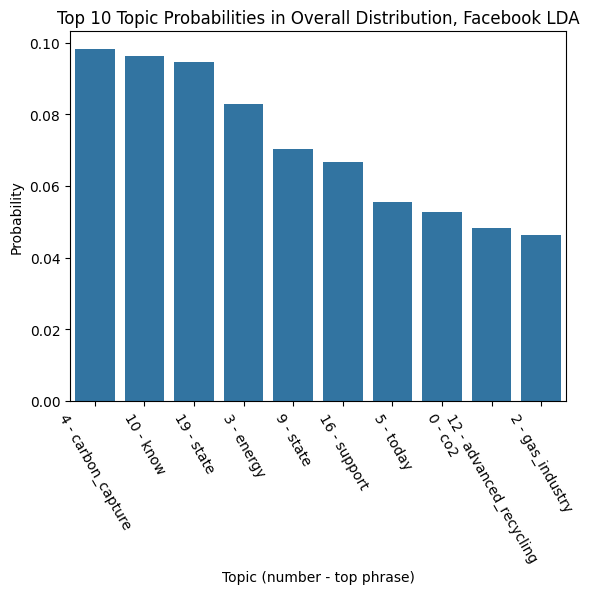

In [31]:
import seaborn as sns
topics = []
for i in range(20):
  # get topic number - word(s) combo for each topic
  topic_words = [w[0] for w in lda_model_facebook.get_topic_words(i, top_n=1)]
  topics.append(f'{i} - {', '.join(topic_words)}')

# Create barplot of probabilities vs topics
data = {'Topic': topics,
        'Probability': overall_topic_dist}
df = pd.DataFrame(data).sort_values(by='Probability',ascending=False)[:10] # get top 10 topics
g = sns.barplot(data=df, x='Topic', y='Probability')
g.tick_params(axis='x', rotation=300)
g.set_title("Top 10 Topic Probabilities in Overall Distribution, Facebook LDA")
g.set_xlabel("Topic (number - top phrase)")

Run intrusion test to evaluate LDA topics. Adapted from Lab 6 - credit to Julia Mendelsohn for writing setup_intrusion_lda() and create_prompt()

In [32]:
# Code to set up topic intrusion test.
# For each topic, sample num_words-1 words from that topic's top 5 words
# And 1 word from a randomly-selected other topic.
# Resulting dataframe contains two columns: the shuffled word list and the intruder word


def setup_intrusion_lda(mdl,num_words=5,samples_per_topic=1):
  samples = []
  # iterate through indexes
  for num_sample in range(samples_per_topic):
    for i in range(mdl.k):
      top_topic_words = [w[0] for w in mdl.get_topic_words(i, top_n=5)]
      true_words = random.sample(top_topic_words,num_words-1)
      other_indexes = [x for x in range(mdl.k) if x!=i]
      other_index = random.choice(other_indexes)
      other_topic_words = [w[0] for w in mdl.get_topic_words(other_index, top_n=5)]
      other_word = random.choice(other_topic_words)
      all_words = true_words + [other_word]
      random.shuffle(all_words)
      samples.append({'words':all_words,
                      'intruder':other_word})
  samples = pd.DataFrame(samples)
  return samples


In [33]:
# Set up the intrusion test for both LDA models

df_eval_lda_nyt = setup_intrusion_lda(lda_model_nyt, samples_per_topic=5)
df_eval_lda_facebook = setup_intrusion_lda(lda_model_facebook, samples_per_topic=5)

In [34]:
# Create a prompt to provide the LLM that takes in the (shuffled) word list.

def create_prompt(word_list):
  prompt = f"You are evaluating results from a topic model with an intrusion test.\
  You will be provided with five words. Four words belong to the same topic, and one word does not belong.\
  Identify the word that does not belong to the same topic as the rest. Do not output anything besides the intruder word.\
  \n \
  Words: {word_list}"
  return prompt

In [35]:
# For each sample in both df's, get the LLM response for which word is the intruder.
# Store results in a new column called "llm_response"

from google.colab import ai # I'm using the built-in colab

def llm_judge(df_eval):
  # Get LLM responses for each prompt
  # Store LLM responses in new column in df_eval
  responses = []
  for i in range(len(df_eval)):
    prompt = create_prompt(df_eval.iloc[i].loc['words']) # use word list from the current row
    responses.append(ai.generate_text(prompt, model_name='google/gemini-2.0-flash-lite')) # use gemini-2.0-flash-lite LLM
  df_eval['response'] = [response.strip() for response in responses] # strip any extra newline characters at the end
  return df_eval

# Run llm_judge on the intrusion samples for both models
df_eval_lda_nyt = llm_judge(df_eval_lda_nyt)
df_eval_lda_facebook = llm_judge(df_eval_lda_facebook)


In [36]:
# Now, calculate the percent of the time the LLM and topic model agree on the intruder
# Which topic model does better on the intrusion test?

def calculate_percent_agree(df_eval):
  # Calculate the percent of the time the LLM and topic model agree on the intruder word
  # Return the percent score
  return (sum(df_eval['intruder'] == df_eval['response'])/len(df_eval)) * 100


percent_agree_lda_nyt = calculate_percent_agree(df_eval_lda_nyt)
percent_agree_lda_facebook = calculate_percent_agree(df_eval_lda_facebook)

print(f"NYT LDA agrees with LLM {percent_agree_lda_nyt:.2f}% of the time")
print(f"Facebook LDA agrees with LLM {percent_agree_lda_facebook:.2f}% of the time")

NYT LDA agrees with LLM 30.00% of the time
Facebook LDA agrees with LLM 28.00% of the time


In [37]:
# Print intrustion test data for nyt lda to make sure no unexpected issues came up
print(df_eval_lda_nyt)

                                                words       intruder response
0              [well, percent, cut, industry, answer]        percent   answer
1          [import, oil, need, environmental, energy]         energy      oil
2      [require, global, co_emission, power, project]          power  project
3             [report, national, say, include, model]        include    model
4               [range, price, finding, import, cost]         import  finding
..                                                ...            ...      ...
95          [percent, work, power, emission, vehicle]           work     work
96    [conclusion, people, include, america, science]        include  america
97        [develop, year, environmental, world, time]  environmental     year
98              [challenge, well, new, energy, world]           well     well
99  [carbon, electricity, carbon_dioxide, vehicle,...        vehicle  vehicle

[100 rows x 3 columns]


In [38]:
# Print intrustion test data for facebook lda to make sure no unexpected issues came up
print(df_eval_lda_facebook)

                                                words       intruder  \
0   [plastic_waste, co2, exxonmobil, reduce, emiss...  plastic_waste   
1    [u.s., public_forum, leader, production, energy]         leader   
2       [economy, support, gas_industry, know, local]           know   
3              [state, exxonmobil, energy, cost, tax]     exxonmobil   
4      [discover, future, leader, economic, american]       american   
..                                                ...            ...   
95         [new, recycling, pledge, survey, time_run]            new   
96         [voice_hear, new, support, lawmaker, tell]            new   
97            [stem, foundation, khan, academy, sign]           sign   
98   [technology, economic, jefferson, state, impact]       economic   
99           [manufacturer, energy, state, help, job]   manufacturer   

      response  
0   exxonmobil  
1       leader  
2         know  
3          tax  
4       future  
..         ...  
95    time_run  

Print top 5 words for each LDA topic in format that can be easily put into a table in LaTeX

In [39]:
# NYT
for i in range(lda_model_nyt.k):
  top_topic_words = [w[0] for w in lda_model_nyt.get_topic_words(i, top_n=5)]
  print(f'{i} & {' '.join(top_topic_words)} \\\\')

0 & cut answer well industry find \\
1 & oil natural_gas need environmental import \\
2 & global level require project co_emission \\
3 & model say report public national \\
4 & international cost price range finding \\
5 & like convert star instal heating \\
6 & emission climate_change economy government percent \\
7 & air nature decline pollution old \\
8 & greenhouse_gas earth temperature scientist carbon_dioxide \\
9 & technology use reduce cost work \\
10 & climate research climate_change change include \\
11 & environmental long_term invest global social \\
12 & power nuclear energy solar renewable \\
13 & u.s. nation emission economic kyoto \\
14 & mobil help support program contribute \\
15 & fuel vehicle percent power emission \\
16 & science people america community conclusion \\
17 & year time develop impact world \\
18 & energy world challenge new develop \\
19 & energy carbon_dioxide carbon gas electricity \\


In [40]:
# Facebook
for i in range(lda_model_facebook.k):
  top_topic_words = [w[0] for w in lda_model_facebook.get_topic_words(i, top_n=5)]
  print(f'{i} & {' '.join(top_topic_words)} \\\\')

0 & co2 emission reduce exxonmobil world \\
1 & energy production public_forum federal_land u.s. \\
2 & gas_industry local oil economy support \\
3 & energy state today tax cost \\
4 & carbon_capture leader future discover economic \\
5 & today oil guideline find official_voting \\
6 & plastic american worker car product \\
7 & natural_gas american taxis reliable electric \\
8 & support exxonmobil school year fuel \\
9 & state storage carbon_capture technology help \\
10 & know oil_natural energy learn gas \\
11 & business gas american oil high \\
12 & advanced_recycling plastic_waste technology address plastic \\
13 & america create new cost manufacturer \\
14 & state pipeline quiz know production \\
15 & survey pledge recycling time_run sign \\
16 & support tell lawmaker important voice_hear \\
17 & help khan academy foundation stem \\
18 & state technology impact county jefferson \\
19 & state job energy support help \\


#BERTopic

Split nyt documents by paragraph

In [41]:
texts = df_nyt['text_modified']

# Handle newlines. Ignore paragraphs for now

texts = [text.replace('\\n\\n', ' PARAGRAPH') for text in texts] #  indicate paragraphs
texts = [text.replace('-\\n','') for text in texts] # dashes followed by newline characters are just one word each
texts = [text.replace('\\n',' ') for text in texts] # all other newline characters should be replcaed by spaces
texts = [text.replace('PARAGRAPH', '\\n\\n') for text in texts] # replace paragraphs with newlines
texts = [re.sub(r'\s+', ' ', text) for text in texts] # replace all multiple whitespace with just one whitespace
df_nyt['text_modified_3'] = texts

In [42]:
df_nyt['text_modified_3'].iloc[0]

' \\n\\nChanging the game \\n\\nResearch into new emissions-reducing technologies could transform our energy future. \\n\\nSupplying energy to meet the needs of growing economies while reducing greenhouse gas emissions is a global challenge we all face. \\n\\nBy 2030, experts predict that the world will require about 60 percent more energy than in 2000. Economic growth in developing countries will account for most of this increase. \\n\\nAs a result, greenhouse gas emissions are predicted to increase too, with developing countries accounting for about 85 percent of carbon dioxide emissions growth between 2000 and 2030. \\n\\nTo meet this challenge, we need practical solutions. Greater energy efficiency is one of them, and it can have a significant impact. By more effectively using fossil fuels, we can reduce the growth in emissions. \\n\\nBiofuels and nuclear power can also play an important role. \\n\\nManaging climate risks on a global scale over the long-term while sustaining econam

In [ ]:
# NOTE: I cleared the print output of this when pushing to github because it is very long
nyt_paragraphs = []
for text in df_nyt['text_modified_3']:
  paragraphs = text.split('\\n\\n') # split each text into paragraphs
  print(paragraphs)
  nyt_paragraphs.append(paragraphs)

In [ ]:
# NOTE: I cleared the print output of this when pushing to github because it is very long
print(nyt_paragraphs)

Combine NYT paragraphs to make sure there are no empty or very short paragraphs

In [45]:
# Combine paragraphs within each doc until their length is > 50
revised_nyt_paragraphs = []
temporary_text = ""
total_text_length = 0
for paragraphs in nyt_paragraphs:
  for paragraph in paragraphs:
    total_text_length += len(paragraph)
    temporary_text = temporary_text + paragraph + " "
    if total_text_length > 50: # if text is paragraph size
      total_text_length = 0
      revised_nyt_paragraphs.append(temporary_text)
      temporary_text = ""
  total_text_length = 0
  temporary_text = ""

In [46]:
revised_nyt_paragraphs[:10]

['  Changing the game  Research into new emissions-reducing technologies could transform our energy future.  ',
 'Supplying energy to meet the needs of growing economies while reducing greenhouse gas emissions is a global challenge we all face.  ',
 'By 2030, experts predict that the world will require about 60 percent more energy than in 2000. Economic growth in developing countries will account for most of this increase.  ',
 'As a result, greenhouse gas emissions are predicted to increase too, with developing countries accounting for about 85 percent of carbon dioxide emissions growth between 2000 and 2030.  ',
 'To meet this challenge, we need practical solutions. Greater energy efficiency is one of them, and it can have a significant impact. By more effectively using fossil fuels, we can reduce the growth in emissions.  ',
 'Biofuels and nuclear power can also play an important role.  ',
 'Managing climate risks on a global scale over the long-term while sustaining econamic growth

In [47]:
print(f'There are {len(revised_nyt_paragraphs)} paragraph docs for NYT BERTopic')

There are 797 paragraph docs for NYT BERTopic


In [48]:
nyt_paragraph_avg_size = np.mean([len(text) for text in revised_nyt_paragraphs])
print(f'Average number of characerts in nyt paragraph: {nyt_paragraph_avg_size}')

Average number of characerts in nyt paragraph: 238.60476787954832


In [49]:
print(f'There are {len(df_facebook['ad_text_modified_2'])} paragraph docs for FB BERTopic')

There are 509 paragraph docs for FB BERTopic


In [50]:
facebook_avg_size = np.mean([len(text) for text in df_facebook['ad_text_modified_2']])
print(f'Average number of characters in fb paragraph: {facebook_avg_size}')

Average number of characters in fb paragraph: 142.47347740667976


We want the number of documents to be more than 1000 ideally, since BERTopic works better when there are more than 1000 docs: https://maartengr.github.io/BERTopic/faq.html#i-have-only-a-few-topics-how-do-i-increase-the

Therefore, let's split the paragraph docs into sentence docs, for both NYT and FB

In [51]:
revised_nyt_sentences = [paragraph.split('. ') for paragraph in revised_nyt_paragraphs] # Split based on period followed by a space (indicating a new sentence in the paragraph)

In [52]:
# Combine NYT sentence docs such that there are no empty or very short sentences
revised_nyt_sentences_one_list = []
temporary_text = ""
total_text_length = 0
for sublist in revised_nyt_sentences:
  for sentence in sublist:
    total_text_length += len(sentence)
    temporary_text = temporary_text + sentence + ". "
    if total_text_length > 20: # make sure it's actually a sentence
      total_text_length = 0
      revised_nyt_sentences_one_list.append(sentence)
      temporary_text = ""
  total_text_length = 0
  temporary_text = ""

In [53]:
print(f'There are {len(revised_nyt_sentences_one_list)} sentences docs for NYT BERTopic')

There are 1652 sentences docs for NYT BERTopic


In [54]:
nyt_sentence_avg_size = np.mean([len(text) for text in revised_nyt_sentences_one_list])
print(f'Average number of characters in NYT sentence: {nyt_sentence_avg_size}')

Average number of characters in NYT sentence: 112.10532687651332


In [55]:
# Combine NYT sentence docs such that there are no empty or very short sentences
revised_facebook_sentences = [text.split('. ') for text in df_facebook['ad_text_modified_2']]
revised_facebook_sentences_one_list = []
temporary_text = ""
total_text_length = 0
for sublist in revised_facebook_sentences:
  for sentence in sublist:
    total_text_length += len(sentence)
    temporary_text = temporary_text + sentence + ". "
    if total_text_length > 20: # make sure it's actually a sentence
      total_text_length = 0
      revised_facebook_sentences_one_list.append(sentence)
      temporary_text = ""
  total_text_length = 0
  temporary_text = ""

In [56]:
print(f'There are {len(revised_facebook_sentences_one_list)} sentence docs for FB BERTopic')

There are 785 sentence docs for FB BERTopic


In [57]:
facebook_sentence_avg_size = np.mean([len(text) for text in revised_facebook_sentences_one_list])
print(f'Average number of characters in FB sentence: {facebook_sentence_avg_size}')

Average number of characters in FB sentence: 89.82165605095541


We now have more than 1000 docs for NYT, and close to 1000 docs for FB. The FB sentences are slightly smaller than the NYT ones, so it's not a great idea to split them up further. Thus, it makes sense to just proceed with BERTopic and see if it creates coherent topics

Run NYT BERTopic

In [58]:
topic_model_nyt = BERTopic(min_topic_size=10) # Use pretty small minimum number of documents per topic, since we don't have many documents
topics, probs = topic_model_nyt.fit_transform(revised_nyt_sentences_one_list)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [59]:
results_df_nyt = topic_model_nyt.get_topic_info()
results_df_nyt

,Topic,Count,Name,Representation,Representative_Docs
0,-1,539,-1_the_and_of_to,"[the, and, of, to, in, that, energy, emissions...",[If developed countries moved to more © effici...
1,0,174,0_the_we_to_will,"[the, we, to, will, are, nations, on, be, that...",[will not “assume binding obligations unless k...
2,1,146,1_climate_change_the_to,"[climate, change, the, to, of, global, warming...",[ Weather and climate In the debate over c...
3,2,63,2_energy_and_world_the,"[energy, and, world, the, of, to, need, npc, w...","[To supply more energy, we’ll need increased i..."
4,3,51,3_kyoto_protocol_the_to,"[kyoto, protocol, the, to, japan, would, in, o...",[“Without full participation by developing cou...
5,4,44,4_exxonmobil_corporate_spills_citizenship,"[exxonmobil, corporate, spills, citizenship, e...",[* ExxonMobil is also leading the way in incre...
6,5,43,5_vehicles_fuel_vehicle_engine,"[vehicles, fuel, vehicle, engine, for, cars, t...",[vehicles of change New technologies help our...
7,6,41,6_gas_natural_coal_fuels,"[gas, natural, coal, fuels, oil, fossil, to, a...",[Everyone recognizes that at some point there ...
8,7,41,7_technology_technologies_technological_also,"[technology, technologies, technological, also...","[Moreover, textbooks hardiy mention the promis..."
9,8,39,8_wind_solar_power_renewable,"[wind, solar, power, renewable, renewables, nu...","[In addition, some renewabies (solar, wind) ha..."


In [60]:
print(f'Number of posts that got assigned to any topic: {results_df_nyt[results_df_nyt['Topic'] != -1]['Count'].sum()}')
print(f'Number of topics: {len(results_df_nyt) - 1}')
print(f'Median number of posts per topic: {results_df_nyt[results_df_nyt['Topic'] != -1]['Count'].median()}')
print(f'Mean number of posts per topic: {results_df_nyt[results_df_nyt['Topic'] != -1]['Count'].mean()}')

Number of posts that got assigned to any topic: 1113
Number of topics: 32
Median number of posts per topic: 22.5
Mean number of posts per topic: 34.78125


In [ ]:
# NOTE: I cleared the output because it uses widgets, and github could not preview the ipynb when widgets were being used
fig_bertopic_nyt = topic_model_nyt.visualize_topics(title="NYT BERTopic")
fig_bertopic_nyt.show()

In [ ]:
# NOTE: I cleared the output because it uses widgets, and github could not preview the ipynb when widgets were being used
# Manually color topics based on the cluster of topics they appear in

# Need to change this section every time the code is run above
k = 5 # manually define num of clusters after running bertopic
indices = range(32)
# write down indices corresponding to which cluster each topic is in (cluster 0 is biggest cluster, cluster k - 1 is smallest)
cluster_indices = {
  0 : [27,7,12,0,15,26,23,31],
  1 : [16,4,6,2,8,9,17],
  2 : [3,13,25,10,24,28,18,20,11,29],
  3 : [19,14,1,30],
  4 : [5,21,22]
}

# function to get sum of the sizes for each topic in a cluster
def get_cluster_size(cluster_indices):
  new_indices = [index + 1 for index in cluster_indices]
  return sum(results_df_nyt.iloc[new_indices]['Count'])

# check which cluster a topic is in ()
def assign_topic_to_cluster(index):
  for i in range(k):
    if index in cluster_indices[i]:
      return i

colors = sns.color_palette("tab10", n_colors=k).as_hex() # convert seaborn palette to hex so that we can use it on plotly
colors_map = map(assign_topic_to_cluster, indices) # assign topic index to its cluster index
colors_indices = list(colors_map) # convert cluster indices to list
print(colors_indices)
colors_list = [colors[index] for index in colors_indices] # get colors

# change colors of topics based on their cluster. Remove borders around topics to better see concentration of topics in a cluster
import plotly.graph_objects as go
fig_bertopic_nyt.update_traces(showlegend=False, marker=dict(color=colors_list, line=dict(width=0)), selector=dict(type='scatter'))

# name clusters for the legend
for i in range(k):
  fig_bertopic_nyt.add_trace(go.Scatter(
      x=[None], y=[None],
      mode='markers',
      name=f'Cluster {i} - Size: {get_cluster_size(cluster_indices[i])}',
      marker=dict(color=colors[i]),
      showlegend=True
  ))

# Place legend in top right corner. Increase font size for readability
fig_bertopic_nyt.update_layout(
    legend=dict(
        font=dict(size=16),
        x=0.55,  # Place outside the right edge of the plot
        y=1,     # Align to the top
        orientation="v", # Vertical orientation (default)
    ),
    xaxis=dict(autorange=True), # autoscale to fit everything
    yaxis=dict(autorange=True)
)
fig_bertopic_nyt.show()

Run FB BERTopic

In [69]:
topic_model_facebook = BERTopic(min_topic_size=10)
topics, probs = topic_model_facebook.fit_transform(revised_facebook_sentences_one_list)

In [70]:
results_df_facebook = topic_model_facebook.get_topic_info()
results_df_facebook

,Topic,Count,Name,Representation,Representative_Docs
0,-1,109,-1_and_the_oil_economy,"[and, the, oil, economy, gas, local, by, santa...",[TAKE ACTION TODAY! Contact your local officia...
1,0,107,0_sign_support_state_petition,"[sign, support, state, petition, to, asap, sen...",[[STATE] needs support from advocates like YOU...
2,1,67,1_carbon_capture_storage_and,"[carbon, capture, storage, and, state, economi...",[Carbon capture and storage projects could cre...
3,2,56,2_recycling_advanced_plastic_waste,"[recycling, advanced, plastic, waste, plastics...",[Merkley to support advanced recycling – a pro...
4,3,54,3_energy_protect_affordable_alert,"[energy, protect, affordable, alert, consumer,...",[• ENERGY ACTION ALERT: Protect affordable ene...
5,4,33,4_guidelines_voting_official_find,"[guidelines, voting, official, find, states, s...",[We can help you find [STATE]’s official votin...
6,5,29,5_oil_gas_natural_learn,"[oil, gas, natural, learn, and, community, ben...",[Did you know oil and natural gas supports mil...
7,6,25,6_exxonmobil_co2_company_storing,"[exxonmobil, co2, company, storing, safely, ca...",[With more CO2 captured than any other company...
8,7,25,7_pipelines_poll_infrastructure_do,"[pipelines, poll, infrastructure, do, depend, ...",[POLL: Pipelines are an essential part of [STA...
9,8,24,8_local_jobs_support_up,"[local, jobs, support, up, energy, protect, pe...","[Sign the petition and support local jobs!, Si..."


In [71]:
print(f'Number of posts that got assigned to any topic: {results_df_facebook[results_df_facebook['Topic'] != -1]['Count'].sum()}')
print(f'Number of topics: {len(results_df_facebook) - 1}')
print(f'Median number of posts per topic: {results_df_facebook[results_df_facebook['Topic'] != -1]['Count'].median()}')
print(f'Mean number of posts per topic: {results_df_facebook[results_df_facebook['Topic'] != -1]['Count'].mean()}')

Number of posts that got assigned to any topic: 676
Number of topics: 24
Median number of posts per topic: 21.0
Mean number of posts per topic: 28.166666666666668


In [ ]:
# NOTE: I cleared the output because it uses widgets, and github could not preview the ipynb when widgets were being used
fig_bertopic_facebook = topic_model_facebook.visualize_topics(title="Facebook BERTopic")
fig_bertopic_facebook.show()

In [ ]:
# NOTE: I cleared the output because it uses widgets, and github could not preview the ipynb when widgets were being used
# Manually color topics based on the cluster of topics they appear in

# Need to change this section every time the code is run above
k = 4 # manually define num of clusters after running bertopic
indices = range(24)
# write down indices corresponding to which cluster each topic is in (cluster 0 is biggest cluster, cluster k - 1 is smallest)
cluster_indices = {
  0 : [21,12,4,10,13,0,22,3,8,11],
  1 : [16,14,17,2,1,15,6],
  2 : [18,9,5,19,7],
  3 : [20,23]
}

# function to get sum of the sizes for each topic in a cluster
def get_cluster_size(cluster_indices):
  new_indices = [index + 1 for index in cluster_indices]
  return sum(results_df_facebook.iloc[new_indices]['Count'])

# check which cluster a topic is in ()
def assign_topic_to_cluster(index):
  for i in range(k):
    if index in cluster_indices[i]:
      return i

colors = sns.color_palette("tab10", n_colors=k).as_hex() # convert seaborn palette to hex so that we can use it on plotly
colors_map = map(assign_topic_to_cluster, indices) # assign topic index to its cluster index
colors_indices = list(colors_map) # convert cluster indices to list
print(colors_indices)
colors_list = [colors[index] for index in colors_indices] # get colors

# change colors of topics based on their cluster. Remove borders around topics to better see concentration of topics in a cluster
import plotly.graph_objects as go
fig_bertopic_facebook.update_traces(showlegend=False, marker=dict(color=colors_list, line=dict(width=0)), selector=dict(type='scatter'))

# name clusters for the legend
for i in range(k):
  fig_bertopic_facebook.add_trace(go.Scatter(
      x=[None], y=[None],
      mode='markers',
      name=f'Cluster {i} - Size: {get_cluster_size(cluster_indices[i])}',
      marker=dict(color=colors[i]),
      showlegend=True
  ))

# Place legend in top right corner. Increase font size for readability
fig_bertopic_facebook.update_layout(
    legend=dict(
        font=dict(size=16),
        x=0.55,  # Place outside the right edge of the plot
        y=1,     # Align to the top
        orientation="v", # Vertical orientation (default)
    ),
    xaxis=dict(autorange=True), # autoscale to fit everything
    yaxis=dict(autorange=True)
)
fig_bertopic_facebook.show()

Visualize topics with highest counts

Text(0.5, 0, 'Topic (number - top phrase)')

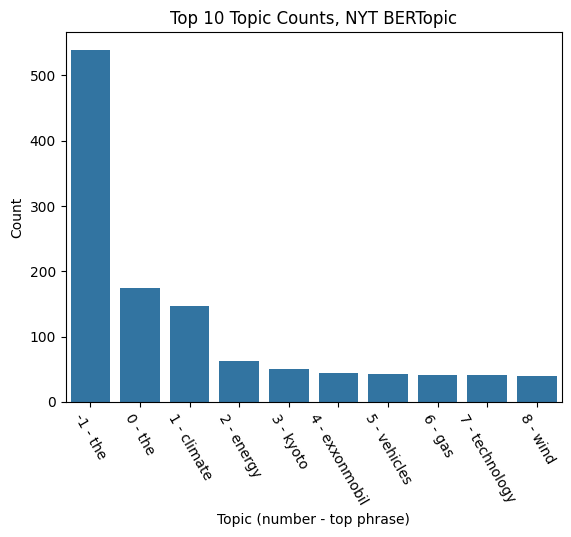

In [80]:
import seaborn as sns
topics = []
k = len(topic_model_nyt.get_topic_info()) - 1 # get number of BERTopic topics, subtracting 1 because of the outlier topic
topic_words = [w[0] for w in topic_model_nyt.get_topic(-1)[:1]] # grab top word(s) from outlier topic
topics.append(f'{-1} - {', '.join(topic_words)}')
for i in range(k):
  # get topic number - word(s) combo for each topic
  topic_words = [w[0] for w in topic_model_nyt.get_topic(i)[:1]]
  topics.append(f'{i} - {', '.join(topic_words)}')

counts = results_df_nyt['Count']

# Create barplot of probabilities vs topics
data = {'Topic': topics,
        'Count': counts}
df = pd.DataFrame(data).sort_values(by='Count',ascending=False)[:10] # get top 10 topics
g = sns.barplot(data=df, x='Topic', y='Count')
g.tick_params(axis='x', rotation=300)
g.set_title("Top 10 Topic Counts, NYT BERTopic")
g.set_xlabel("Topic (number - top phrase)")

Text(0.5, 0, 'Topic (number - top phrase)')

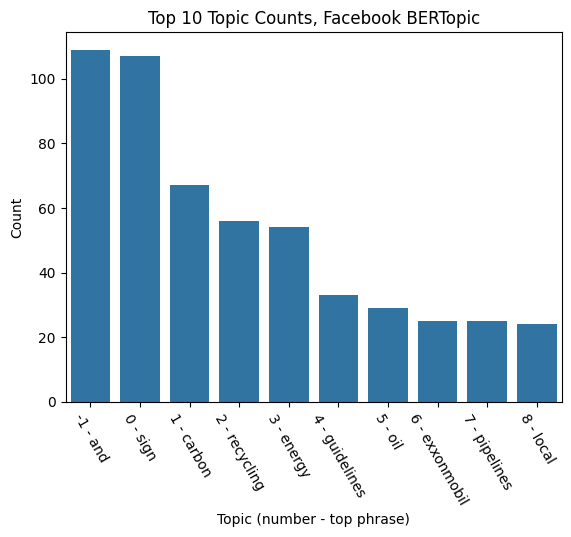

In [81]:
import seaborn as sns
topics = []
k = len(topic_model_facebook.get_topic_info()) - 1 # get number of BERTopic topics, subtracting 1 because of the outlier topic
topic_words = [w[0] for w in topic_model_facebook.get_topic(-1)[:1]] # grab top word(s) from outlier topic
topics.append(f'{-1} - {', '.join(topic_words)}')
for i in range(k):
  # get topic number - word(s) combo for each topic
  topic_words = [w[0] for w in topic_model_facebook.get_topic(i)[:1]]
  topics.append(f'{i} - {', '.join(topic_words)}')

counts = results_df_facebook['Count']

# Create barplot of probabilities vs topics
data = {'Topic': topics,
        'Count': counts}
df = pd.DataFrame(data).sort_values(by='Count',ascending=False)[:10] # get top 10 topics
g = sns.barplot(data=df, x='Topic', y='Count')
g.tick_params(axis='x', rotation=300)
g.set_title("Top 10 Topic Counts, Facebook BERTopic")
g.set_xlabel("Topic (number - top phrase)")

Run intrusion test to evaluate BERTopic topics

In [82]:
# Code to set up topic intrusion test for BERTopic
# For each topic, sample num_words-1 words from that topic's top 5 words
# And 1 word from a randomly-selected other topic.
# Resulting dataframe contains two columns: the shuffled word list and the intruder word


def setup_intrusion_bertopic(mdl,num_words=5,samples_per_topic=1):
  samples = []
  k = len(mdl.get_topic_info()) - 1 # get number of BERTopic topics, subtracting 1 because of the outlier topic
  # iterate through indexes
  for num_sample in range(samples_per_topic):
    for i in range(k):
      top_topic_words = [w[0] for w in mdl.get_topic(i)[:5]]
      true_words = random.sample(top_topic_words,num_words-1)
      other_indexes = [x for x in range(k) if x!=i]
      other_index = random.choice(other_indexes)
      other_topic_words = [w[0] for w in mdl.get_topic(other_index)[:5]]
      other_word = random.choice(other_topic_words)
      all_words = true_words + [other_word]
      random.shuffle(all_words)
      samples.append({'words':all_words,
                      'intruder':other_word})
  samples = pd.DataFrame(samples)
  return samples

In [83]:
# Set up the intrusion test for both BERTopic models

# YOUR CODE HERE
df_eval_bertopic_nyt = setup_intrusion_bertopic(topic_model_nyt,samples_per_topic=5)
df_eval_bertopic_facebook = setup_intrusion_bertopic(topic_model_facebook,samples_per_topic=5)

In [84]:
# Run llm_judge on the intrusion samples for both models. Use same prompt as for LDA results earlier
df_eval_bertopic_nyt = llm_judge(df_eval_bertopic_nyt)
df_eval_bertopic_facebook = llm_judge(df_eval_bertopic_facebook)

percent_agree_1 = calculate_percent_agree(df_eval_bertopic_nyt)
percent_agree_2 = calculate_percent_agree(df_eval_bertopic_facebook)

print(f"Model 1 agrees with LLM {percent_agree_1:.2f}% of the time")
print(f"Model 2 agrees with LLM {percent_agree_2:.2f}% of the time")

Model 1 agrees with LLM 58.13% of the time
Model 2 agrees with LLM 30.83% of the time


In [85]:
print(df_eval_bertopic_facebook)

                                                 words     intruder  \
0                   [petition, way, to, sign, support]          way   
1            [capture, storage, and, community, state]    community   
2         [plastics, waste, recycling, alert, plastic]        alert   
3    [protect, affordable, energy, alert, contributed]  contributed   
4          [voting, states, federally, official, find]    federally   
..                                                 ...          ...   
115        [test, quiz, knowledge, offshore, drilling]         quiz   
116        [production, oil, waters, federally, owned]          oil   
117  [support, policymakers, stimulating, embrace, ...      support   
118           [interior, and, department, july, sales]          and   
119              [revenue, risk, interior, ban, march]     interior   

       response  
0           way  
1           and  
2         alert  
3    affordable  
4          find  
..          ...  
115    offshore  
116

Print top 5 words for each BERTopic topic, along with the document counts, in format that can be easily put into a table in LaTeX

In [86]:
k = len(topic_model_nyt.get_topic_info()) - 1 # get number of BERTopic topics, subtracting 1 because of the outlier topic
top_topic_words = [w[0] for w in topic_model_nyt.get_topic(-1)[:5]]
print(f'{-1} & {' '.join(top_topic_words)} & {results_df_nyt.iloc[0]['Count']} \\\\')
for i in range(k):
  top_topic_words = [w[0] for w in topic_model_nyt.get_topic(i)[:5]]
  print(f'{i} & {' '.join(top_topic_words)} & {results_df_nyt.iloc[i+1]['Count']} \\\\')

-1 & the and of to in & 539 \\
0 & the we to will are & 174 \\
1 & climate change the to of & 146 \\
2 & energy and world the of & 63 \\
3 & kyoto protocol the to japan & 51 \\
4 & exxonmobil corporate spills citizenship environmental & 44 \\
5 & vehicles fuel vehicle engine for & 43 \\
6 & gas natural coal fuels oil & 41 \\
7 & technology technologies technological also can & 41 \\
8 & wind solar power renewable renewables & 39 \\
9 & cogeneration steam energy efficiency units & 38 \\
10 & emissions reduce technology without can & 37 \\
11 & greenhouse gases effect atmosphere heat & 36 \\
12 & us percent the substantial they & 30 \\
13 & emission trading emissions controls their & 26 \\
14 & environment environmental nature environmentalists point & 25 \\
15 & senate treaty senator resolution vote & 23 \\
16 & mobil mobils doing concerns synthetic & 22 \\
17 & gcep stanford university project research & 21 \\
18 & greenhouse emissions reduce gas gases & 21 \\
19 & forests conservation

In [87]:
k = len(topic_model_facebook.get_topic_info()) - 1 # get number of BERTopic topics, subtracting 1 because of the outlier topic
top_topic_words = [w[0] for w in topic_model_facebook.get_topic(-1)[:5]]
print(f'{-1} & {' '.join(top_topic_words)} & {results_df_facebook.iloc[0]['Count']} \\\\')
for i in range(k):
  top_topic_words = [w[0] for w in topic_model_facebook.get_topic(i)[:5]]
  print(f'{i} & {' '.join(top_topic_words)} & {results_df_facebook.iloc[i+1]['Count']} \\\\')

-1 & and the oil economy gas & 109 \\
0 & sign support state petition to & 107 \\
1 & carbon capture storage and state & 67 \\
2 & recycling advanced plastic waste plastics & 56 \\
3 & energy protect affordable alert consumer & 54 \\
4 & guidelines voting official find states & 33 \\
5 & oil gas natural learn and & 29 \\
6 & exxonmobil co2 company storing safely & 25 \\
7 & pipelines poll infrastructure do depend & 25 \\
8 & local jobs support up energy & 24 \\
9 & recovery accelerate wages provided oil & 23 \\
10 & confirm details today your information & 21 \\
11 & gas natural potentially limiting ending & 21 \\
12 & american businesses tax at taxing & 21 \\
13 & survey priorities take quiz out & 20 \\
14 & emissions co2 efforts support lawmakers & 20 \\
15 & ccs unlock its help learn & 18 \\
16 & regulations unnecessary stand way ineffective & 17 \\
17 & hydrogen could domestic dominance tens & 16 \\
18 & contributed vital community play supporting & 16 \\
19 & drilling offshore qui